In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression

In [3]:
input_file = "../simple_gen_missing_data.csv"

df = pd.read_csv(input_file)
vars = df.columns[1:]
year_col = "t"

In [5]:
# Imputation by most common value per variable (aka popularity)
output_file = "../simple_gen_popularity_imputation.csv"
df_popular_imp = df.copy()

def mode_impute(group):
    for var in vars:
        mode_values = group[var].mode()
        group[var] = group[var].fillna(mode_values.iloc[0])
    return group

df_popular_imp = df_popular_imp.groupby(year_col, group_keys=False).apply(mode_impute)
df_popular_imp.to_csv(output_file, index=False, na_rep='')

C:\Users\ryanr\AppData\Local\Temp\ipykernel_29708\2462068381.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_popular_imp = df_popular_imp.groupby(year_col, group_keys=False).apply(mode_impute)


In [6]:
# Imputation by probability distribution of existing values
output_file = "../simple_gen_probability_imputation.csv"
df_prob_imp = df.copy()

def prob_impute(group):
    for var in vars:
        # Get the distribution of non-missing values
        freq_table = group[var].value_counts(dropna=True)
        distinct_vals = freq_table.index.to_list()
        probabilities = (freq_table / freq_table.sum()).to_list()

        print(f'Variable {var}: values {distinct_vals} probability {probabilities}')
        
        # Identify which rows are missing
        missing_mask = group[var].isna()
        n_missing = missing_mask.sum()
        
        # Randomly sample from the distinct values, using the same distribution
        random_draws = np.random.choice(distinct_vals, size=n_missing, p=probabilities)
        
        # Fill in the missing values
        group.loc[missing_mask, var] = random_draws
    return group

df_prob_imp = df_prob_imp.groupby(year_col, group_keys=False).apply(prob_impute)
df_prob_imp.to_csv(output_file, index=False)

Variable X1: values [0.0, 1.0] probability [0.7846034214618973, 0.21539657853810265]
Variable X2: values [0.0, 1.0] probability [0.8967811158798283, 0.10321888412017168]
Variable X3: values [0.0, 1.0] probability [0.8286001507916562, 0.1713998492083438]
Variable X4: values [0.0, 1.0] probability [0.9620770128354725, 0.037922987164527425]
Variable X5: values [0.0, 1.0] probability [0.858554342173687, 0.14144565782631305]
Variable X6: values [0.0, 1.0] probability [0.8626160990712074, 0.13738390092879257]
Variable X7: values [0.0, 1.0] probability [0.9144736842105263, 0.08552631578947369]
Variable X1: values [0.0, 1.0] probability [0.8015151515151515, 0.1984848484848485]
Variable X2: values [0.0, 1.0] probability [0.9041037635551775, 0.09589623644482245]
Variable X3: values [0.0, 1.0] probability [0.8254764292878636, 0.17452357071213642]
Variable X4: values [0.0, 1.0] probability [0.9414985590778098, 0.0585014409221902]
Variable X5: values [0.0, 1.0] probability [0.8650793650793651, 0.13

C:\Users\ryanr\AppData\Local\Temp\ipykernel_29708\2396861610.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_prob_imp = df_prob_imp.groupby(year_col, group_keys=False).apply(prob_impute)


In [ ]:
output_file = "../simple_gen_logreg_imputation.csv"
df_logreg_imputed = df.copy()
def logreg_impute(group):
    constant_cols = [
        col for col in vars 
        if group[col].dropna().nunique() <= 1
    ]
    # Columns that can be processed by IterativeImputer (i.e., have more than one unique value)
    non_constant_cols = [col for col in vars if col not in constant_cols]

    # For constant columns, fill missing values with the constant value
    for col in constant_cols:
        non_missing = group[col].dropna()
        if not non_missing.empty:
            group[col] = group[col].fillna(non_missing.iloc[0])
    imputer = IterativeImputer(
        estimator=LogisticRegression(),
        max_iter=10,
        random_state=0
    )

    group[non_constant_cols] = imputer.fit_transform(group[non_constant_cols])
    return group

df_logreg_imputed = df_logreg_imputed.groupby(year_col, group_keys=False).apply(logreg_impute)
df_logreg_imputed.to_csv(output_file, index=False)

C:\Users\ryanr\AppData\Local\Temp\ipykernel_29708\1486330587.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_logreg_imputed = df_logreg_imputed.groupby(year_col, group_keys=False).apply(logreg_impute)


In [9]:
output_file = "../simple_gen_KNN_imputation.csv"
df_KNN_imputed = df.copy()
def KNN_impute(group):
    constant_cols = [
        col for col in vars 
        if group[col].dropna().nunique() <= 1
    ]
    # Columns that can be processed by IterativeImputer (i.e., have more than one unique value)
    non_constant_cols = [col for col in vars if col not in constant_cols]

    # For constant columns, fill missing values with the constant value
    for col in constant_cols:
        non_missing = group[col].dropna()
        if not non_missing.empty:
            group[col] = group[col].fillna(non_missing.iloc[0])
    imputer = KNNImputer(n_neighbors=4)

    group[non_constant_cols] = imputer.fit_transform(group[non_constant_cols])
    return group

df_KNN_imputed = df_KNN_imputed.groupby(year_col, group_keys=False).apply(KNN_impute)
df_KNN_imputed.to_csv(output_file, index=False)

C:\Users\ryanr\AppData\Local\Temp\ipykernel_29708\2999782347.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_KNN_imputed = df_KNN_imputed.groupby(year_col, group_keys=False).apply(KNN_impute)


In [11]:
def compute_graph_covariance(df: pd.DataFrame, time_col: str = 't') -> dict:
    """
    Computes a 'graph covariance'-like matrix for each unique time step in `df`,
    returning each matrix as a DataFrame (so .loc indexing is supported).
    
    Steps:
      1. Split the data by unique time values,
      2. For each time step, convert the sub-DataFrame (minus the time column)
         to a NumPy array,
      3. Subtract the mean from each column (center the data),
      4. Normalize each column by its standard deviation,
      5. Compute the covariance-like matrix for that time step,
      6. Return a dictionary keyed by time with the resulting DataFrame.

    Returns
    -------
    dict
        Dictionary where each key is a unique time value and the value is a
        DataFrame containing the covariance-like matrix.
    """
    # Identify all columns other than time_col
    other_cols = [col for col in df.columns if col != time_col]
    
    # Split data into time steps
    unique_times = df[time_col].unique()
    gc_dict = {}

    for t_value in unique_times:
        # Subset the DataFrame to the current time step
        subset_df = df[df[time_col] == t_value].drop(columns=[time_col])
        data_t = subset_df.values.astype(float)

        if data_t.shape[0] < 2:
            continue

        # Mean-center the data
        n = data_t.shape[0]
        mean = data_t.mean(axis=0, keepdims=True)
        data_centered = data_t - mean

        # Normalize each column
        stds = data_centered.std(axis=0, ddof=1, keepdims=True)
        
        # Avoid division by zero
        stds[stds == 0] = 1.0
        data_centered /= stds

        # Compute the covariance-like matrix
        graph_covariance = (data_centered.T @ data_centered) / (n - 1)

        # Convert to DataFrame
        cov_df = pd.DataFrame(graph_covariance, 
                              index=subset_df.columns, 
                              columns=subset_df.columns)
        
        # Store the DataFrame
        gc_dict[t_value] = cov_df

    return gc_dict

In [26]:
df1 = pd.read_csv(r"C:\Users\ryanr\Desktop\anti-trafficking\simple_gen_data.csv") # Original "ground truth"
df2 = pd.read_csv(r"C:\Users\ryanr\Desktop\anti-trafficking\simple_gen_KNN_imputation.csv") # Imputed dataset

In [27]:
# Compute graph covariance for both datasets
gc_matrices1 = compute_graph_covariance(df1, time_col="t")
gc_matrices2 = compute_graph_covariance(df2, time_col="t")

# Ensure times are aligned (using intersection of time points)
times1 = sorted(gc_matrices1.keys())
times2 = sorted(gc_matrices2.keys())
common_times = sorted(set(times1) & set(times2))

In [28]:
# Extract covariance values for both datasets
gc1_12 = [gc_matrices1[t].loc["X1","X2"] for t in common_times]
gc1_13 = [gc_matrices1[t].loc["X1","X3"] for t in common_times]
gc1_14 = [gc_matrices1[t].loc["X1","X4"] for t in common_times]
gc1_15 = [gc_matrices1[t].loc["X1","X5"] for t in common_times]
gc1_16 = [gc_matrices1[t].loc["X1","X6"] for t in common_times]
gc1_17 = [gc_matrices1[t].loc["X1","X7"] for t in common_times]

gc2_12 = [gc_matrices2[t].loc["X1","X2"] for t in common_times]
gc2_13 = [gc_matrices2[t].loc["X1","X3"] for t in common_times]
gc2_14 = [gc_matrices2[t].loc["X1","X4"] for t in common_times]
gc2_15 = [gc_matrices2[t].loc["X1","X5"] for t in common_times]
gc2_16 = [gc_matrices2[t].loc["X1","X6"] for t in common_times]
gc2_17 = [gc_matrices2[t].loc["X1","X7"] for t in common_times]

In [29]:
# Shift second line to match first
def shift_series(base_series, imputed_series):
    """Shift imputed_series so that its first value matches the first value of base_series."""
    offset = base_series[0] - imputed_series[0]
    return [val + offset for val in imputed_series]

gc2_12_shifted = shift_series(gc1_12, gc2_12)
gc2_13_shifted = shift_series(gc1_13, gc2_13)
gc2_14_shifted = shift_series(gc1_14, gc2_14)
gc2_15_shifted = shift_series(gc1_15, gc2_15)
gc2_16_shifted = shift_series(gc1_16, gc2_16)
gc2_17_shifted = shift_series(gc1_17, gc2_17)

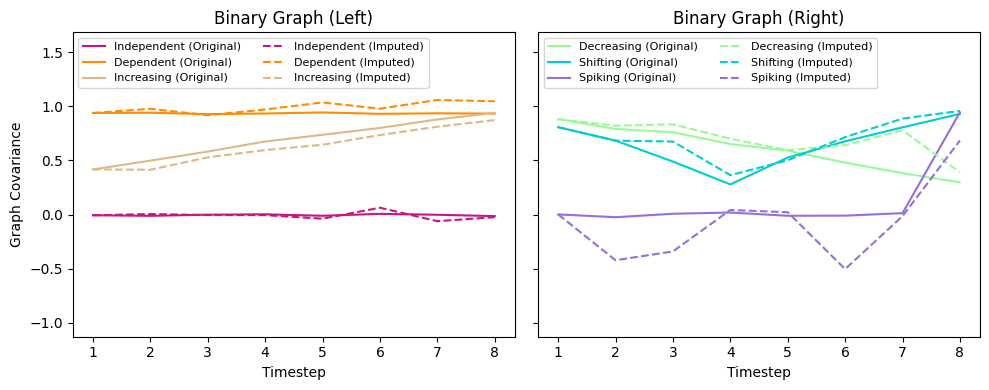

In [30]:
# Create the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# LEFT PLOT: (X1,X2), (X1,X3), (X1,X4)
ax1.plot(common_times, gc1_12, color='mediumvioletred',   linestyle='-',  label='Independent (Original)')
ax1.plot(common_times, gc1_13, color='darkorange',        linestyle='-',  label='Dependent (Original)')
ax1.plot(common_times, gc1_14, color='burlywood',         linestyle='-',  label='Increasing (Original)')
ax1.plot(common_times, gc2_12_shifted, color='mediumvioletred', linestyle='--', label='Independent (Imputed)')
ax1.plot(common_times, gc2_13_shifted, color='darkorange',      linestyle='--', label='Dependent (Imputed)')
ax1.plot(common_times, gc2_14_shifted, color='burlywood',       linestyle='--', label='Increasing (Imputed)')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Graph Covariance')
ax1.set_title('Binary Graph (Left)')
ax1.legend(loc='upper left', fontsize='8', ncol=2)
# RIGHT PLOT: (X1,X5), (X1,X6), (X1,X7)
ax2.plot(common_times, gc1_15, color='palegreen',   linestyle='-', label='Decreasing (Original)')
ax2.plot(common_times, gc1_16, color='darkturquoise', linestyle='-', label='Shifting (Original)')
ax2.plot(common_times, gc1_17, color='mediumpurple', linestyle='-', label='Spiking (Original)')
ax2.plot(common_times, gc2_15_shifted, color='palegreen',   linestyle='--', label='Decreasing (Imputed)')
ax2.plot(common_times, gc2_16_shifted, color='darkturquoise', linestyle='--', label='Shifting (Imputed)')
ax2.plot(common_times, gc2_17_shifted, color='mediumpurple', linestyle='--', label='Spiking (Imputed)')
ax2.set_xlabel('Timestep')
ax2.set_title('Binary Graph (Right)')
ax2.legend(loc='upper left', fontsize='8', ncol=2)

# --- GLOBAL Y-LIMITS ---
all_data_original = np.concatenate([
    gc1_12, gc1_13, gc1_14,
    gc1_15, gc1_16, gc1_17
])
all_data_imputed = np.concatenate([
    gc2_12_shifted, gc2_13_shifted, gc2_14_shifted,
    gc2_15_shifted, gc2_16_shifted, gc2_17_shifted
])
all_data = np.concatenate([all_data_original, all_data_imputed])

global_min = np.min(all_data)
global_max = np.max(all_data)
data_range = global_max - global_min
margin = 0.4 * data_range
y_lower = global_min - margin
y_upper = global_max + margin

ax1.set_ylim(y_lower, y_upper)
ax2.set_ylim(y_lower, y_upper)

plt.tight_layout()
plt.show()

In [62]:
df_true = pd.read_csv(r"C:\Users\ryanr\Desktop\anti-trafficking\simple_gen_data.csv") # Original "ground truth"
df_imputed = pd.read_csv(r"C:\Users\ryanr\Desktop\anti-trafficking\simple_gen_logreg_imputation.csv") # Imputed dataset
# df_imputed = pd.read_csv(r"C:\Users\ryanr\Desktop\anti-trafficking\simple_gen_probability_imputation.csv") # Imputed dataset


In [63]:
cols = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']

assert df_true.shape[0] == df_imputed.shape[0], "Dataframes do not have the same number of rows"
assert all(df_true['t'] == df_imputed['t']), "The time columns do not match row by row"

print("Percentage of 0s and 1s in original dataset (per variable):")
for col in cols:
    pct_0 = (df_true[col] == 0).mean() * 100
    pct_1 = (df_true[col] == 1).mean() * 100
    print(f"{col}: 0 -> {pct_0:.2f}%, 1 -> {pct_1:.2f}%")

Percentage of 0s and 1s in original dataset (per variable):
X1: 0 -> 80.40%, 1 -> 19.60%
X2: 0 -> 89.94%, 1 -> 10.05%
X3: 0 -> 82.41%, 1 -> 17.59%
X4: 0 -> 89.21%, 1 -> 10.79%
X5: 0 -> 91.30%, 1 -> 8.70%
X6: 0 -> 90.16%, 1 -> 9.84%
X7: 0 -> 88.91%, 1 -> 11.09%


In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score
y_true = df_true[cols].values.flatten().astype(np.int64)      # Flatten 2D array into 1D
y_imputed = df_imputed[cols].values.flatten().astype(np.int64)

global_accuracy = accuracy_score(y_true, y_imputed)
global_precision = precision_score(y_true, y_imputed, zero_division=0)
global_recall = recall_score(y_true, y_imputed, zero_division=0)
global_f1 = f1_score(y_true, y_imputed, zero_division=0)

print("Global Metrics (all X columns combined):")
print(f"Concordance (Accuracy): {global_accuracy:.3f}")
print(f"Precision:               {global_precision:.3f}")
print(f"Recall:                  {global_recall:.3f}")
print(f"F1-Score:                {global_f1:.3f}")

print(f"{global_accuracy:.3f}, {global_precision:.3f}, {global_recall:.3f}, {global_f1:.3f}")

Global Metrics (all X columns combined):
Concordance (Accuracy): 0.969
Precision:               0.941
Recall:                  0.803
F1-Score:                0.867
0.969, 0.941, 0.803, 0.867


In [65]:
def shift_series(base_series, imputed_series):
    """
    Shift imputed_series so that its first value matches 
    the first value of base_series.
    """
    if not base_series:  # if empty
        return imputed_series
    offset = base_series[0] - imputed_series[0]
    return [val + offset for val in imputed_series]

def mean_squared_error(series1, series2):
    diff = np.array(series1) - np.array(series2)
    return np.mean(diff ** 2)

In [66]:
gc_matrices1 = compute_graph_covariance(df_true, time_col="t")
gc_matrices2 = compute_graph_covariance(df_imputed, time_col="t")

times1 = sorted(gc_matrices1.keys())
times2 = sorted(gc_matrices2.keys())
common_times = sorted(set(times1) & set(times2))

# Example pairs: (X1,X2), (X1,X3), etc.
gc1_12 = [gc_matrices1[t].loc["X1","X2"] for t in common_times] if common_times else []
gc1_13 = [gc_matrices1[t].loc["X1","X3"] for t in common_times] if common_times else []
gc1_14 = [gc_matrices1[t].loc["X1","X4"] for t in common_times] if common_times else []
gc1_15 = [gc_matrices1[t].loc["X1","X5"] for t in common_times] if common_times else []
gc1_16 = [gc_matrices1[t].loc["X1","X6"] for t in common_times] if common_times else []
gc1_17 = [gc_matrices1[t].loc["X1","X7"] for t in common_times] if common_times else []

gc2_12 = [gc_matrices2[t].loc["X1","X2"] for t in common_times] if common_times else []
gc2_13 = [gc_matrices2[t].loc["X1","X3"] for t in common_times] if common_times else []
gc2_14 = [gc_matrices2[t].loc["X1","X4"] for t in common_times] if common_times else []
gc2_15 = [gc_matrices2[t].loc["X1","X5"] for t in common_times] if common_times else []
gc2_16 = [gc_matrices2[t].loc["X1","X6"] for t in common_times] if common_times else []
gc2_17 = [gc_matrices2[t].loc["X1","X7"] for t in common_times] if common_times else []

gc2_12_shifted = shift_series(gc1_12, gc2_12)
gc2_13_shifted = shift_series(gc1_13, gc2_13)
gc2_14_shifted = shift_series(gc1_14, gc2_14)
gc2_15_shifted = shift_series(gc1_15, gc2_15)
gc2_16_shifted = shift_series(gc1_16, gc2_16)
gc2_17_shifted = shift_series(gc1_17, gc2_17)


pairs_original = [gc1_12, gc1_13, gc1_14, gc1_15, gc1_16, gc1_17]
pairs_imputed  = [gc2_12_shifted, gc2_13_shifted, gc2_14_shifted,
                  gc2_15_shifted, gc2_16_shifted, gc2_17_shifted]
pair_names = ["(X1,X2)", "(X1,X3)", "(X1,X4)", "(X1,X5)", "(X1,X6)", "(X1,X7)"]

# Compute 1 - MSE for each pair
similarity_values = []
for orig_series, imp_series, name in zip(pairs_original, pairs_imputed, pair_names):
    if len(orig_series) == 0 or len(imp_series) == 0:
        print(f"\nNo data for pair {name}; cannot compute 1 - MSE.")
        similarity_values.append(np.nan)
        continue
    
    mse_val = mean_squared_error(orig_series, imp_series)
    similarity = 1 - mse_val   # 1 - MSE
    similarity_values.append(similarity)
    
    print(f"1 - MSE for {name}: {similarity:.4f}")

# Overall average of (1 - MSE) across all pairs
valid_sims = [val for val in similarity_values if not np.isnan(val)]
if len(valid_sims) > 0:
    avg_similarity = np.mean(valid_sims)
    print(f"\nAverage (1 - MSE) across all pairs: {avg_similarity:.4f}")
else:
    print("\nNo valid (1 - MSE) values to average.")

1 - MSE for (X1,X2): 1.0000
1 - MSE for (X1,X3): 0.9999
1 - MSE for (X1,X4): 0.9898
1 - MSE for (X1,X5): 0.9709
1 - MSE for (X1,X6): 0.9808
1 - MSE for (X1,X7): 0.9988

Average (1 - MSE) across all pairs: 0.9900
